# Imports

In [5]:
import pandas as pd
import numpy as np

import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

import lightning as L

from sklearn.preprocessing import MinMaxScaler

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import joblib

import requests

C:\Users\23603526\AppData\Local\Temp\ipykernel_17176\1431678637.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Toolbox

In [21]:
def get_dates(weeks_ = 52):
    today = datetime.now()

    today_rounded_down = today.replace(minute=0, second=0, microsecond=0)

    one_year_ago = today - timedelta(days=weeks_ * 7 + 1)

    one_year_ago_rounded = one_year_ago.replace(minute=0, second=0, microsecond=0)

    if one_year_ago.minute != 0 or one_year_ago.second != 0 or one_year_ago.microsecond != 0:
        one_year_ago_rounded += timedelta(hours=1)

    formatted_today_rounded_down = today_rounded_down.strftime("%Y-%m-%dT%H:%M:%S")
    formatted_one_year_ago_rounded = one_year_ago_rounded.strftime("%Y-%m-%dT%H:%M:%S")

    return formatted_one_year_ago_rounded, formatted_today_rounded_down, today


def train(dm= None, folder='models_2', train_models=True, load_train=False, rfr=True, xgb_=True, knn=True, ridge=True, window_size=24, step=1):
    if dm.column == None:
        uni_multi = 'multi'
    else:
        uni_multi = 'uni'

    if train_models:

        X_ = dm.f_train.reshape(-1, window_size * dm.df.shape[1])
        X_valid = dm.f_valid.reshape(-1, window_size * dm.df.shape[1])

        if dm.column == None:
            y_ = dm.t_train[:,:,2]
            y_valid = dm.t_valid[:,:,2]
        else:
            y_ = dm.t_train
            y_valid = dm.t_valid


        if rfr:
            start_time = time.time()

            print('Training Random Forest Regressor...')

            if load_train:
                print('Loading model...')
                rf_regressor_1 = RandomForestRegressor(n_estimators=50, random_state=42, warm_start=True)
                rf_regressor_1 = joblib.load(f'{folder}/random_forest_model_{uni_multi}_ws_{window_size}_s_{step}.pkl') 
                print('Model loaded...')
            else:
                rf_regressor_1 = RandomForestRegressor(n_estimators=50, random_state=42)       
        
                
            rf_regressor_1.fit(X_, y_)

            end_time = time.time()

            elapsed_minutes = (end_time - start_time) / 60
            print(f"Elapsed minutes: {elapsed_minutes}")
            print('\n\n')

            joblib.dump(rf_regressor_1, f'{folder}/random_forest_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')
                
        if xgb_:
            start_time = time.time()

            print('Training XGBoost Model...')
            
            rf_regressor_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', learning_rate=0.01,
                                                    max_depth=3, n_estimators=1000,
                                                    objective='reg:linear', random_state=0)
        
        

            rf_regressor_xgb.fit(X_, y_, eval_set=[(X_valid, y_valid)], 
                                early_stopping_rounds=10, 
                                verbose=False)

            end_time = time.time()

            elapsed_minutes = (end_time - start_time) / 60
            print(f"Elapsed minutes: {elapsed_minutes}")
            print('\n\n')

            model_path = f"{folder}/xgboost_model_{uni_multi}_ws_{window_size}_s_{step}.bin"
            rf_regressor_xgb.save_model(model_path)  
                
        if knn:
            start_time = time.time()
            
            print('Training KNN Regressor...')
            knn_regressor = KNeighborsRegressor(n_neighbors=10) 
            knn_regressor.fit(X_, y_)

            end_time = time.time()

            elapsed_minutes = (end_time - start_time) / 60
            print(f"Elapsed minutes: {elapsed_minutes}")
            print('\n\n')

            joblib.dump(knn_regressor, f'{folder}/knn_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

        if ridge:
            start_time = time.time()

            print('Training ridge Regressor...')
            
            ridge_model = Ridge(alpha=0.15)  

            ridge_model.fit(X_, y_)

            end_time = time.time()

            elapsed_minutes = (end_time - start_time) / 60 
            print(f"Elapsed minutes: {elapsed_minutes}")    
            print('\n\n')

            joblib.dump(ridge_model, f'{folder}/ridge_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    # else:
    #     rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    #     rfr_model = joblib.load(f'{folder}/random_forest_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    #     xgb_model = xgb.XGBRegressor()
    #     xgb_model.load_model(f'{folder}/xgboost_model_{uni_multi}_ws_{window_size}_s_{step}.bin')
        
    #     knn_model = joblib.load(f'{folder}/knn_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    #     ridge_model = joblib.load(f'{folder}/ridge_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    #     print('Models loaded...')

    # return rfr_model, xgb_model, knn_model, ridge_model

def load_models(dm = None, folder='models_2', window_size=24, step=1):
    if dm.column == None:
        uni_multi = 'multi'
    else:
        uni_multi = 'uni'

    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model = joblib.load(f'{folder}/random_forest_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    xgb_model = xgb.XGBRegressor()
    xgb_model.load_model(f'{folder}/xgboost_model_{uni_multi}_ws_{window_size}_s_{step}.bin')
    
    knn_model = joblib.load(f'{folder}/knn_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    ridge_model = joblib.load(f'{folder}/ridge_regressor_model_{uni_multi}_ws_{window_size}_s_{step}.pkl')

    print('Models loaded...')

    return rfr_model, xgb_model, knn_model, ridge_model

# Data Extract

## Wind Farm Locations

In [7]:
wind_farms = [
    {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

wind_farms_df = pd.DataFrame(wind_farms)
wind_farms_df[['latitude', 'longitude']] = pd.DataFrame(wind_farms_df['location'].tolist())
wind_farms_df.drop('location', axis=1, inplace=True)
wind_farms_df = wind_farms_df.set_index('name')

## Extract from OpenWeatherMap

In [8]:
needed = False

Not needed


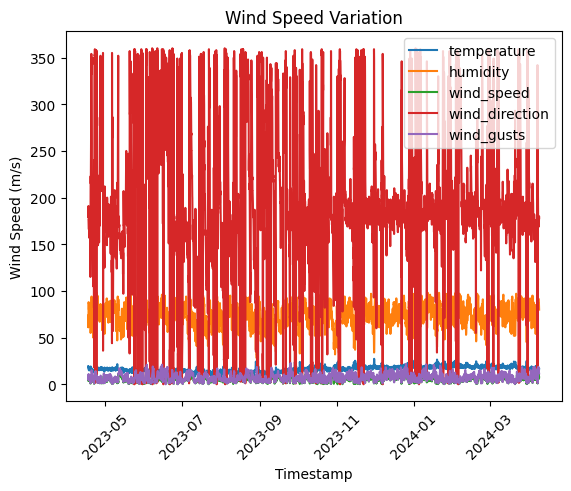

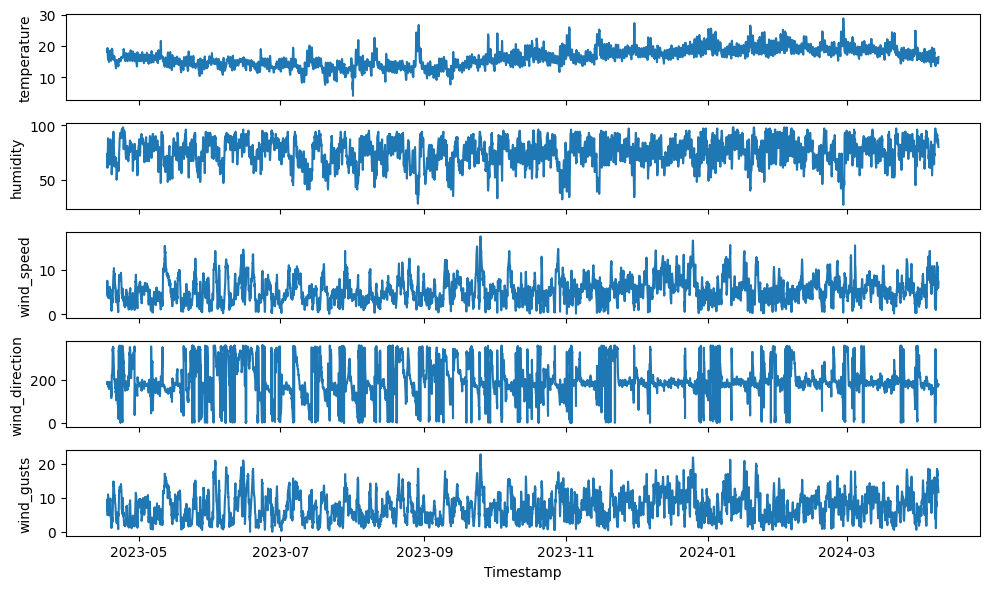

In [9]:
api_key = '7552f271b24168a6c4ef09611a862ff8'
base_url = f'https://api.openweathermap.org/data/2.5/weather'


farm = 'Aurora Wind Power'
latitude = wind_farms_df.loc[farm]['latitude']
longitude = wind_farms_df.loc[farm]['longitude']

if needed:
    weather_data = []

    weeks = 52

    start_timestamp_iso, end_timestamp_iso, today = get_dates(weeks_=weeks)
    end_timestamp_unix = int(datetime.fromisoformat(end_timestamp_iso).timestamp())
    start_timestamp_unix = int(datetime.fromisoformat(start_timestamp_iso).timestamp())

    for i in range(weeks):
        print(f'Progress: {i}/{weeks}', end='\r')
        start_timestamp_unix += 604800
        end_timestamp_unix = start_timestamp_unix + 604800
        

        url = f'https://history.openweathermap.org/data/2.5/history/city?lat={latitude}&lon={longitude}&start={start_timestamp_unix}&end={end_timestamp_unix}&appid={api_key}&units=metric'

        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()

            
            for item in data['list']:
                timestamp = item['dt']
                datetime_obj = datetime.utcfromtimestamp(timestamp)
                timestamp_iso = datetime_obj.isoformat()
                temperature = item['main']['temp']
                humidity = item['main']['humidity']
                wind_speed = item['wind']['speed']
                wind_direction = item['wind']['deg']
                try:
                    wind_gusts = item['wind']['gust']
                except:
                    wind_gusts = 0
                weather_data.append({'timestamp': timestamp_iso, 'temperature': temperature, 
                                    'humidity': humidity, 'wind_speed': wind_speed, 
                                    'wind_direction': wind_direction, 'wind_gusts' : wind_gusts})
        
            weather_df = pd.DataFrame(weather_data)
            weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
            weather_df.set_index('timestamp', inplace=True)
        else:
            # Print an error message if the request was unsuccessful
            print(f"Error: {response.status_code}")
            print(url)

    weather_df.to_csv(f'data/weather_data_{farm}.csv')

    print('Gathered data')
else:
    weather_df = pd.read_csv(f'data/weather_data_{farm}.csv', index_col='timestamp', parse_dates=True)
    print('Not needed')

plt.plot(weather_df)
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Variation')
plt.legend(weather_df.columns)
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots(nrows=len(weather_df.columns), ncols=1, figsize=(10, 6), sharex=True)

# Plot each feature
for i, column in enumerate(weather_df.columns):
    axes[i].plot(weather_df.index, weather_df[column], label=column)
    axes[i].set_ylabel(column)

# Set common x-axis label
axes[-1].set_xlabel('Timestamp')

plt.tight_layout()
plt.show()



# Data Module

In [10]:
class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=2, batch_size=64, window_size=5, normalize_=False,
                 date_range = None, step_ = 24):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_

        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets = self.window_step(self.df, self.step_)
        self.windows, self.targets = self.windows.squeeze(), self.targets.squeeze()

    def window_step(self, dataset, step_ ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-self.window_size - step_):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return X_r.float(), y_r.float()
    
    def normalize(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.fit_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.fit_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_normalze(self, series):
        if self.column == None:
            return pd.DataFrame(self.scaler.inverse_transform(series), index=series.index)
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_single_column(self, series, column = 2):
        if self.column == None:
            zeros_ = pd.DataFrame(np.zeros((series.shape[0], 5)))
            zeros_[column] = series 
            return pd.DataFrame(self.scaler.inverse_transform(zeros_))[column]
        else:
            return pd.DataFrame(self.scaler.inverse_transform(series.reshape(-1, 1)))

    def setup(self, stage: str):
        split = [round(len(self.targets) * 0.7), round(len(self.targets) * 0.9)]

        self.f_train, self.t_train = self.windows[:split[0]], self.targets[:split[0]]
        self.f_valid, self.t_valid = self.windows[split[0]:split[1]], self.targets[split[0]:split[1]]
        self.f_test, self.t_test = self.windows[split[1]:], self.targets[split[1]:]

        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)


## Visually Inspect Data Module

In [11]:
window_size = 24 * 3 
step = 24

In [12]:
#TODO: Add visual inspection graphs

Train: torch.Size([5983, 72, 5])
Valid: torch.Size([1709, 72, 5])
Test: torch.Size([855, 72, 5])


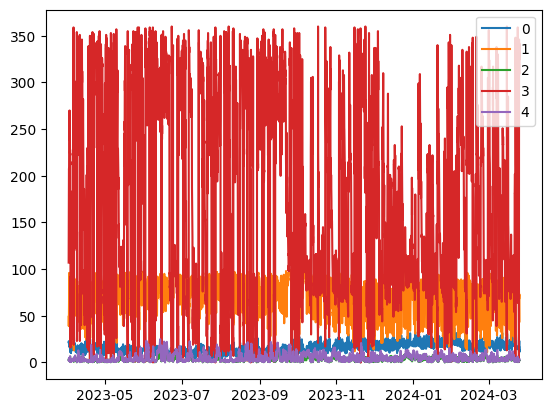

In [13]:
dm = WeatherDataModule(window_size=window_size, column=None,batch_size=32, step_=24, normalize_=True)
dm.prepare_data()
dm.setup('')

plt.plot(dm.inverse_normalze(dm.df))
plt.legend(dm.df.columns)
plt.show()

# Training

In [29]:
window_size = 24*3
step = 24

### Univariate Forecasting
# column_ = 2

### Multivariate Forecasting
column_ = None

dm = WeatherDataModule(data_dir='data\weather_data_Aurora Wind Power.csv', 
                       window_size=window_size, column=column_,
                       batch_size=32, step_=step, 
                       normalize_=True)

dm.prepare_data()
dm.setup('')

# train(dm= dm, folder='models_2', train_models=True, load_train=False, rfr=True, xgb_=True, knn=True, ridge=True, window_size=window_size, step=step)
rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder='models_2', window_size=window_size, step=step)

Train: torch.Size([5983, 72, 5])
Valid: torch.Size([1709, 72, 5])
Test: torch.Size([855, 72, 5])
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


# Testing

## Validation Set

Mean MSE for Random Forest: 5.587976939222455
Mean MSE for XGBoost: 5.421418487870177
Mean MSE for kNN: 7.104005325660535
Mean MSE for Ridge: 5.456111299509793
Mean MSE for Average: 5.168462109076519


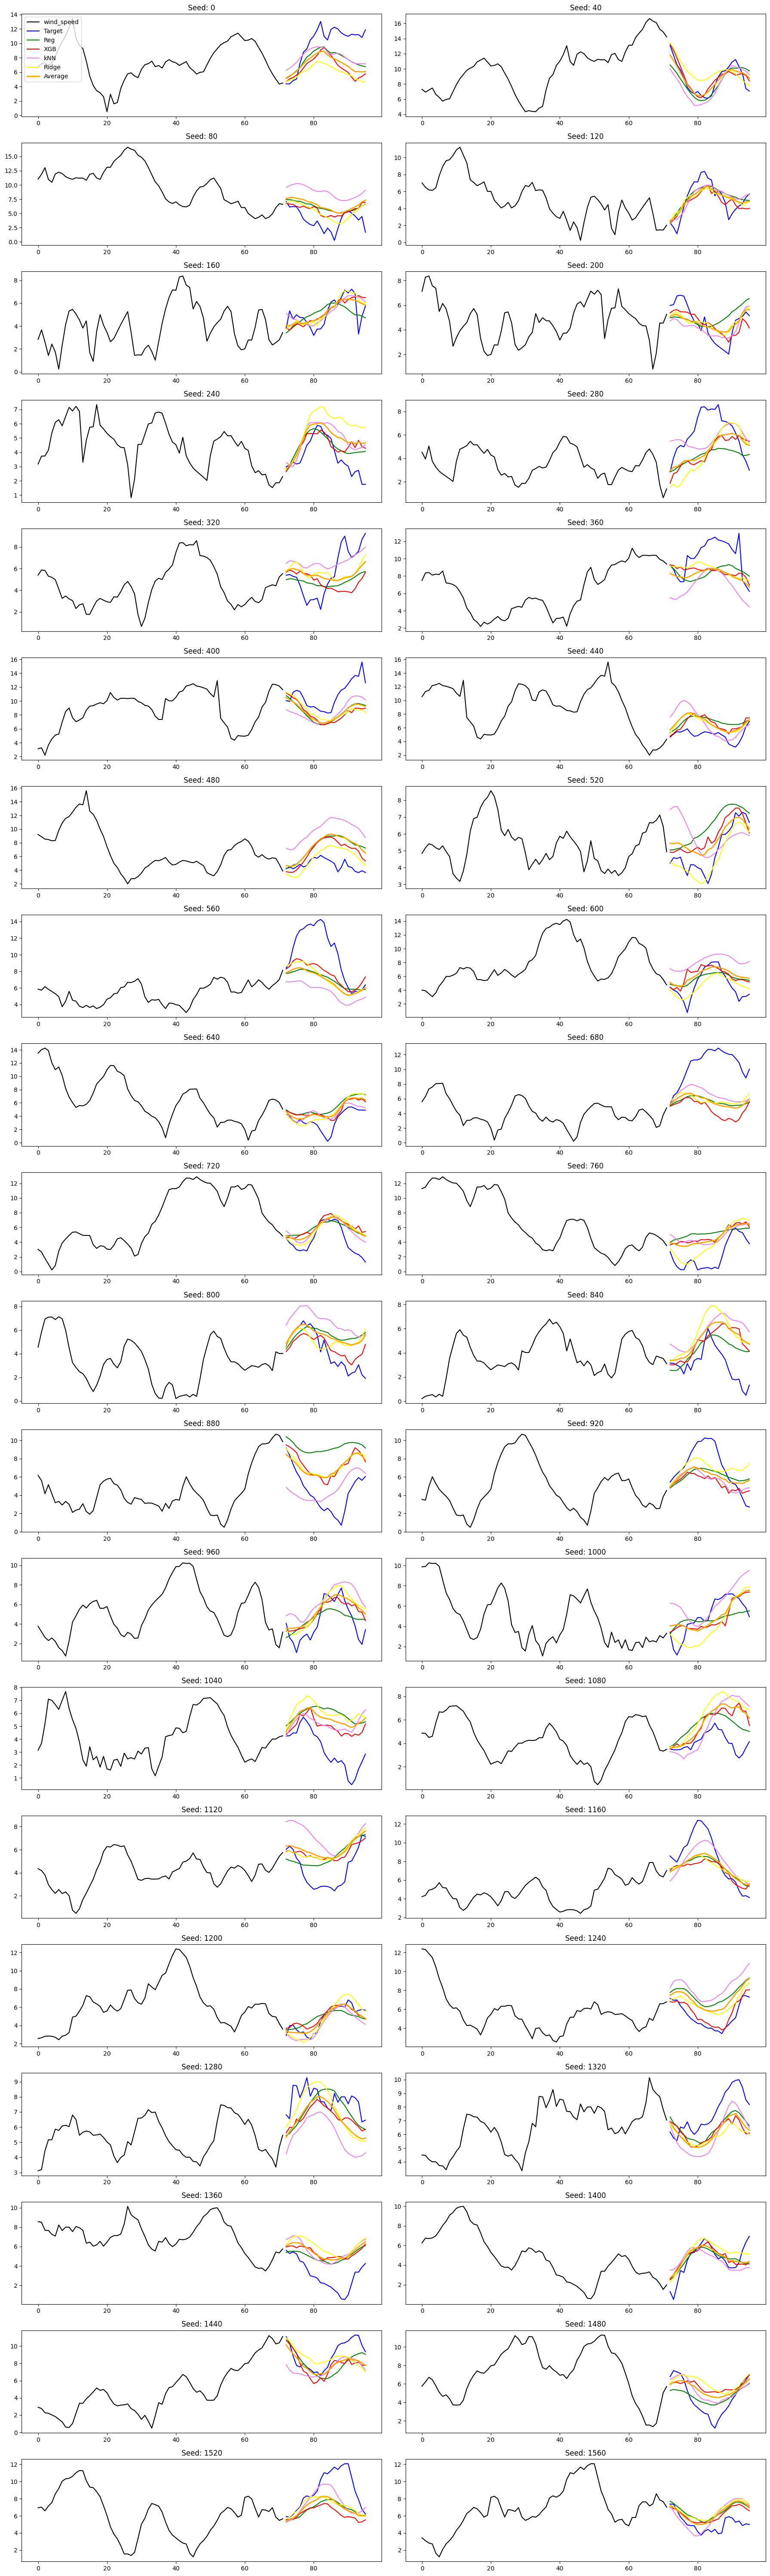

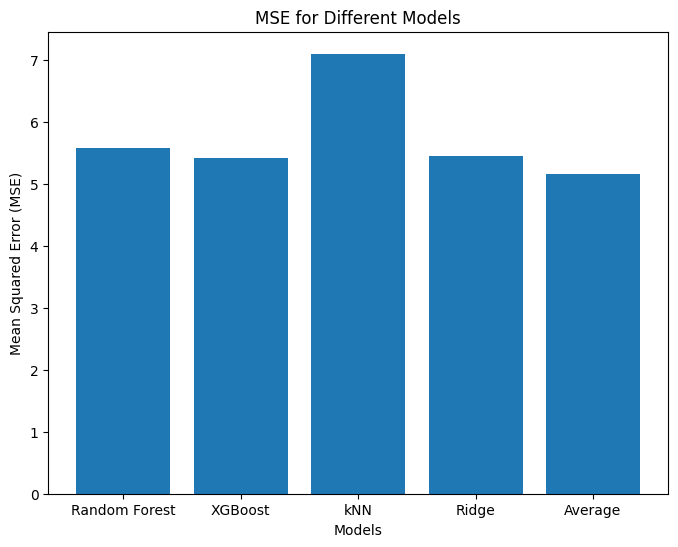

In [30]:
def plot_results(seed, height, width, interval, X, y, rfr_model, xgb_model, knn_model, ridge_model, plot_features=True, metrics=True, weights_ = [0.25, 0.25, 0.25, 0.25]):

    mse_rfr = []
    mse_xgb = []
    mse_knn = []
    mse_ridge = []
    mse_avg = []

    mse_tracker = {'Random Forest': mse_rfr, 'XGBoost': mse_xgb, 'kNN': mse_knn, 'Ridge': mse_ridge, 'Average': mse_avg}

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            seed_index = i * 2 + j
            seed = seed_index * interval 
            current_data = X[seed]

            current_data_ = current_data.reshape(1, window_size * dm.df.shape[1])

            step_pred_rfr = rfr_model.predict(current_data_).squeeze()
            step_pred_xgb = xgb_model.predict(current_data_).squeeze()
            step_pred_knn = knn_model.predict(current_data_).squeeze()
            step_pred_ridge = ridge_model.predict(current_data_).squeeze()

            average = step_pred_rfr * weights_[0] + step_pred_xgb * weights_[1] + step_pred_knn * weights_[2] + step_pred_ridge * weights_[3]

            if dm.column == None:
                t_test_data = y[seed:seed + step][0][:, 2]
                current_data = current_data[:, 2]
            else:
                t_test_data = y[seed]

            if plot_features:
                ax.plot(range(window_size), current_data[:, 0], label='temperature', c='gray')
                ax.plot(range(window_size), current_data[:, 1], label='humidity', c='gray')
                ax.plot(range(window_size), current_data[:, 3], label='wind_direction', c='gray')
                ax.plot(range(window_size), current_data[:, 4], label='wind_gusts', c='gray')

            if dm.normalize_: 
                ax.plot(range(window_size), dm.inverse_single_column(current_data), label='wind_speed', c='black')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(t_test_data), label = 'Target', c='blue')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_rfr), label = 'Reg', c='green')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_xgb), label = 'XGB', c='red')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_knn), label = 'kNN', c='violet')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(step_pred_ridge), label = 'Ridge', c='yellow')
                ax.plot(range(window_size, window_size + step), dm.inverse_single_column(average), label = 'Average', c='orange', linewidth=2)

                mse_rfr.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_rfr)))
                mse_xgb.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_xgb)))
                mse_knn.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_knn)))
                mse_ridge.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(step_pred_ridge)))
                mse_avg.append(mean_squared_error(dm.inverse_single_column(t_test_data), dm.inverse_single_column(average)))

            else:
                ax.plot(range(window_size), current_data, label='wind_speed', c='black')
                ax.plot(range(window_size, window_size + step), t_test_data, label = 'Target', c='blue')
                ax.plot(range(window_size, window_size + step), step_pred_rfr, label = 'Reg', c='green')
                ax.plot(range(window_size, window_size + step), step_pred_xgb, label = 'XGB', c='red')     
                ax.plot(range(window_size, window_size + step), step_pred_knn, label = 'kNN', c='violet')
                ax.plot(range(window_size, window_size + step), step_pred_ridge, label = 'Ridge', c='yellow')
                ax.plot(range(window_size, window_size + step), average, label = 'Average', c='orange', linewidth=2)

                mse_rfr.append(mean_squared_error(t_test_data, step_pred_rfr))
                mse_xgb.append(mean_squared_error(t_test_data, step_pred_xgb))
                mse_knn.append(mean_squared_error(t_test_data, step_pred_knn))
                mse_ridge.append(mean_squared_error(t_test_data, step_pred_ridge))
                mse_avg.append(mean_squared_error(t_test_data, average))

            if i == 0 and j == 0:  
                ax.legend(loc='upper left')

            ax.set_title(f"Seed: {seed}")

    if metrics:
        for key, value in mse_tracker.items():
            print(f'Mean MSE for {key}: {np.mean(value)}')
        

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.bar(mse_tracker.keys(), [np.mean(value) for value in mse_tracker.values()])
    plt.xlabel('Models')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE for Different Models')
    plt.show()

    return [np.mean(value) for value in mse_tracker.values()]

seed = 0 
interval = 40
metrics = True
plot_features = False

mse_ = plot_results(seed, 20, 2, interval, dm.f_valid, dm.t_valid, rfr_model, xgb_model, knn_model, ridge_model, plot_features=plot_features, metrics=metrics)
weights = mse_[:4]/sum(mse_[:4])
weights = min(weights)/weights * max(weights)

## Test Set

Mean MSE for Random Forest: 3.6557459503670926
Mean MSE for XGBoost: 3.9562308164988855
Mean MSE for kNN: 4.34165033942338
Mean MSE for Ridge: 3.2444531158851526
Mean MSE for Average: 3.294710935585175


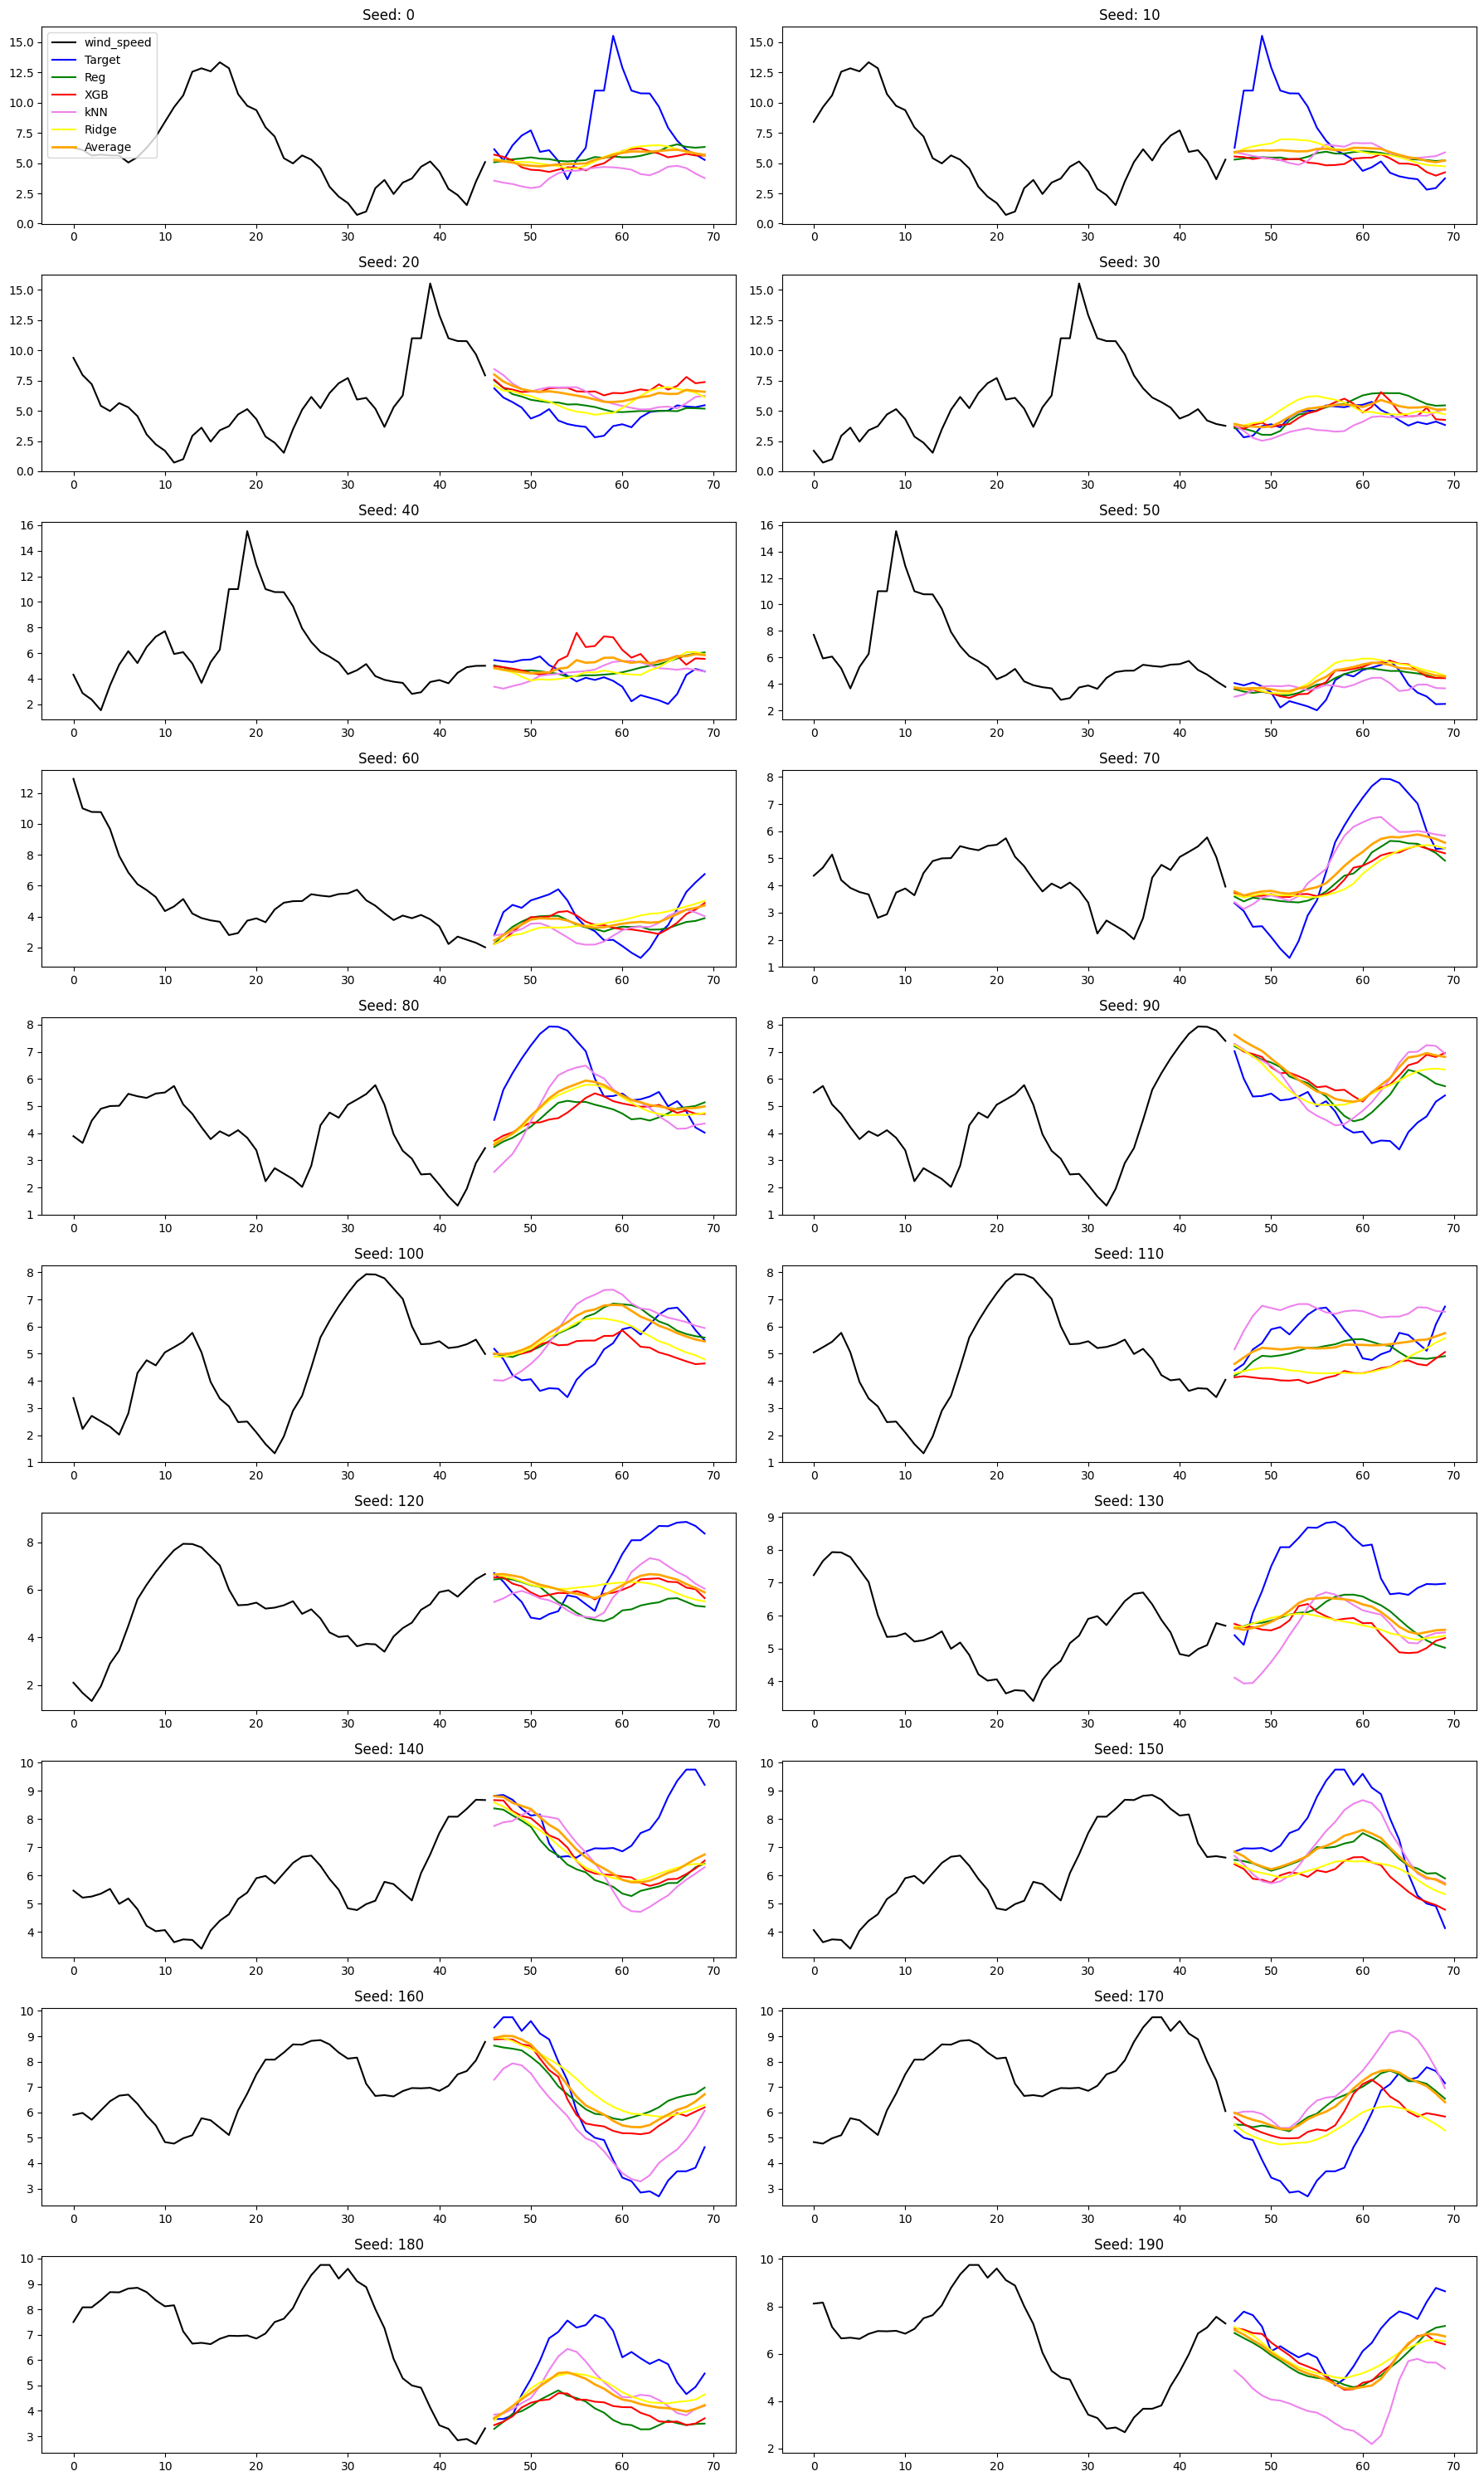

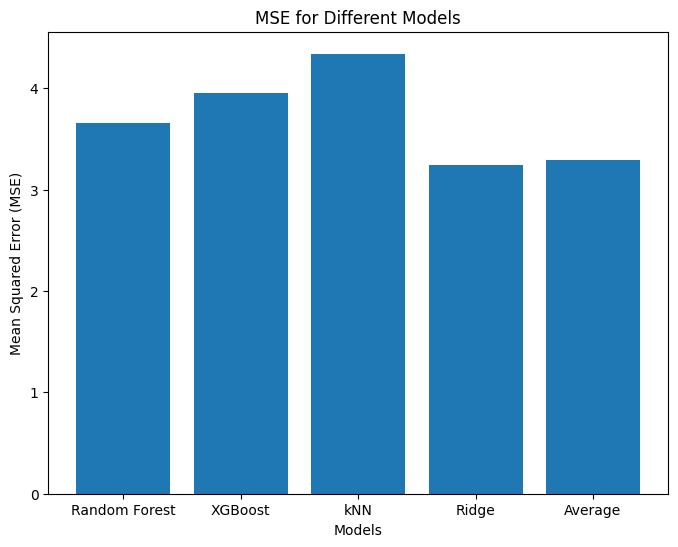

In [24]:
interval = 10

_ = plot_results(seed, 10, 2, interval, dm.f_test, dm.t_test, rfr_model, xgb_model, knn_model, ridge_model, plot_features=plot_features, metrics=metrics, weights_=weights)   

# Quick Result

MSE for Average model: 0.018041568420830875
MSE for kNN model: 0.022966959
MSE for Ridge model: 0.014946623059796342
MSE for Random Forest model: 0.015340079034003704
MSE for XGBoost model: 0.0142496675


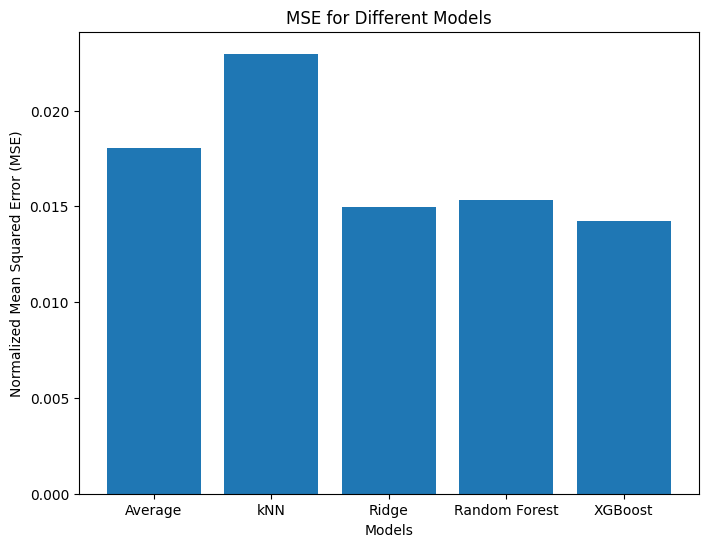

In [31]:
if dm.column == None:
    y_true = dm.t_test[:, :, 2]
else:
    y_true = dm.t_test


y_pred_knn = knn_model.predict(dm.f_test.reshape(-1, window_size * dm.df.shape[1]))
y_pred_ridge = ridge_model.predict(dm.f_test.reshape(-1, window_size * dm.df.shape[1]))
y_pred_rfr = rfr_model.predict(dm.f_test.reshape(-1, window_size * dm.df.shape[1]))
y_pred_xgb = xgb_model.predict(dm.f_test.reshape(-1, window_size * dm.df.shape[1]))
y_pred_avg = y_pred_rfr * weights[0] + y_pred_xgb * weights[1] + y_pred_knn * weights[2] + y_pred_ridge * weights[3]


mse_avg = mean_squared_error(y_true, y_pred_avg)
mse_knn = mean_squared_error(y_true, y_pred_knn)
mse_ridge = mean_squared_error(y_true, y_pred_ridge)
mse_rfr = mean_squared_error(y_true, y_pred_rfr)
mse_xgb = mean_squared_error(y_true, y_pred_xgb)

# Print MSE for each model
print("MSE for Average model:", mse_avg)
print("MSE for kNN model:", mse_knn)
print("MSE for Ridge model:", mse_ridge)
print("MSE for Random Forest model:", mse_rfr)
print("MSE for XGBoost model:", mse_xgb)

plt.figure(figsize=(8, 6))  
plt.bar(['Average', 'kNN', 'Ridge', 'Random Forest', 'XGBoost'], [mse_avg, mse_knn, mse_ridge, mse_rfr, mse_xgb])
plt.xlabel('Models')
plt.ylabel('Normalized Mean Squared Error (MSE)')
plt.title('MSE for Different Models')
plt.show()